In [1]:
%reload_ext autoreload
%autoreload 3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import matplotlib.animation as animation
from scipy.stats import binom
import matplotlib as mpl
from sklearn import datasets
import itertools

from utils import *

In [54]:
X_0 = np.random.rand(15,2) + 1
X_1 = np.random.rand(15,2) - 1
X = np.concatenate([X_0, X_1])

X = datasets.make_moons(n_samples=30, noise=0.05)[0].astype(np.float32)
#X = datasets.make_blobs(n_samples=100, centers=3)[0].astype(np.float32)
#np.random.shuffle(X)

In [55]:
def build_mat(X, M=5):
    W, D_sqinv = compute_G0(X)
    L = compute_laplacian(W, D_sqinv)
    A = compute_AM_normalised(L, D_sqinv, M)
    W, g = compute_Ge(A)
    g.compute_A()
    g.kruskal_algo()
    mat = g.compute_mat()
    return mat, g, W

In [56]:
mat, g, W = build_mat(X)

g = Graph(4)
#g.add_edge(0, 1, 4)
#g.add_edge(0, 2, 1)
#g.add_edge(0, 3, 2)
#g.add_edge(1, 2, 5)
#g.add_edge(1, 3, 3)
#g.add_edge(2, 3, 8)
g.add_edge(0, 1, 8)
g.add_edge(0, 2, 6)
g.add_edge(0, 3, 1)
g.add_edge(1, 2, 2)
g.add_edge(1, 3, 5)
g.add_edge(2, 3, 4)



g.compute_A()
g.kruskal_algo()
g.compute_mat()

omega = g.omega
V = g.V

MM = np.zeros((2 * g.V - 1, 3))
for i in range(g.V):
    MM[i, 0] = True
    MM[i, 1] = i
    MM[i, 2] = 1e8
for i in range(g.V, 2 * g.V - 1):
    if compute_nfa(mat[i, 4] / omega, V , mat[i, 5]) < MM[int(mat[i, 2]), 2] and compute_nfa(mat[i, 4] / omega, V , mat[i, 5]) < MM[int(mat[i, 3]), 2]:
        MM[i, 0] = True
        MM[i, 1] = i
        MM[i, 2] = compute_nfa(mat[i, 4] / omega, V , mat[i, 5])
        MM[int(mat[i, 2]), 0] = False
        MM[int(mat[i, 3]), 0] = False
    elif compute_nfa(mat[i, 4] / omega, V , mat[i, 5]) < MM[int(mat[i, 2]), 2]:
        MM[i, 1] = MM[int(mat[i, 3]), 1]
        MM[i, 2] = MM[int(mat[i, 3]), 2]
        MM[int(mat[i, 2]), 0] = False
    elif compute_nfa(mat[i, 4] / omega, V , mat[i, 5]) < MM[int(mat[i, 3]), 2]:
        MM[i, 1] = MM[int(mat[i, 2]), 1]
        MM[i, 2] = MM[int(mat[i, 2]), 2]
        MM[int(mat[i, 3]), 0] = False
    else:
        if MM[int(mat[i, 2]), 2] < MM[int(mat[i, 3]), 2]:
            MM[i, 1] = MM[int(mat[i, 2]), 1]
            MM[i, 2] = MM[int(mat[i, 2]), 2]
        else:
            MM[i, 1] = MM[int(mat[i, 3]), 1]
            MM[i, 2] = MM[int(mat[i, 3]), 2]
        

In [57]:
deltas = np.array([0.0000000e+00, 2.0000000e-10, 1.4000000e-09, 4.4600000e-08,
       4.0204000e-06, 3.2262400e-05, 2.4599640e-04, 1.5910262e-03,
       7.9717572e-03, 0.0000000e+00]) # pour size=30
deltas = np.array([0.0000000e+00, 4.0000000e-10, 2.4000000e-09, 1.7420000e-07,
       7.9780000e-06, 5.6434000e-05, 5.7970960e-04, 2.1720470e-03,
       9.7363586e-03, 0.0000000e+00]) * 100



#deltas = np.maximum(deltas, 1e-8) + 0.001

#deltas = np.array([1] * 10)


In [58]:
K = 10
omega = g.omega
V = g.V

MM = np.zeros((2 * g.V - 1, 3))
for i in range(g.V):
    MM[i, 0] = False
    MM[i, 1] = 1e8
    MM[i, 2] = 1e8
    
MM[-1,0] = True
MM[-1,1] = compute_pfa(mat[-1, 4] / omega, V , mat[-1, 5])
MM[-1,2] = compute_nfa(mat[-1, 4] / omega, V , mat[-1, 5], deltas)

def recur(mat, mini, ind_mini, ind, V):
    if ind < V:
        return True
    V_ = mat[ind, 5]
    MM[ind, 1] = compute_pfa(mat[ind, 4] / omega, V , V_)
    MM[ind, 2] = compute_nfa(mat[ind, 4] / omega, V , V_, deltas)
    if MM[ind, 2] <= mini and MM[ind, 1] < deltas[hash_function(V_, K, V)]:
        MM[ind, 0] = True
        MM[ind_mini, 0] = False
        return recur(mat, MM[ind, 2], ind, int(mat[ind, 2]), V) and recur(mat, MM[ind, 2], ind, int(mat[ind, 3]), V)
    return recur(mat, mini, ind_mini, int(mat[ind, 2]), V) and recur(mat, mini, ind_mini, int(mat[ind, 3]), V)

In [59]:
recur(mat, 1, len(MM)-1, len(MM)-1, g.V)

True

In [60]:
g.omega

40.65104245942409

In [61]:
ind = -2
V_ = mat[ind, 5]
hash_function(V_, K, V)

6

In [62]:
MM[ind, 1]

0.002907646957965415

In [63]:
mat[ind, 4]

19.013552144351017

In [64]:
MM[ind, 1] < deltas[hash_function(V_, K, V)]

True

In [65]:
compute_pfa(mat[ind, 4] / omega, V , V_)

0.002907646957965415

In [66]:
compute_pfa(7 / omega, V , V_)

2.1655677251430916e-11

In [67]:
MM

array([[0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000000e+08, 1.00000000e+08],
       [0.00000000e+00, 1.00000

In [68]:
mat[-2]

array([58.        , 51.        , 55.        , 56.        , 19.01355214,
       21.        ,  1.        ,  1.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        1.        ,  1.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ])

cmap = mpl.colormaps['hsv']

nb_clusters = sum(MM[:,0])

fig, ax = plt.subplots()
ax.plot(X[:,0], X[:,1], 'ko', markersize=4)
for j in range(g.V):
    if mat[-2, j + 6]:
        ax.plot(X[j,0], X[j,1], markersize=4, marker='o')


In [70]:
res = 0
for i in range(len(MM)):
    if MM[i,0]:
        res += mat[i, 5]
print(res)

21.0


Nb clusters: 1.0


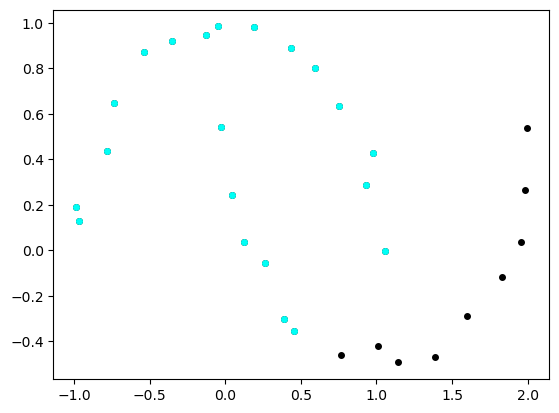

In [75]:
cmap = mpl.colormaps['hsv']

nb_clusters = sum(MM[:,0])

fig, ax = plt.subplots()
ax.plot(X[:,0], X[:,1], 'ko', markersize=4)
clu = 0
for i in range(len(mat)):
    if MM[i,0]:
        clu += 1
        for j in range(g.V):
            if mat[i, j + 6]:
                ax.plot(X[j,0], X[j,1], markersize=4, color=cmap(clu / (nb_clusters+1)), marker='o')
                
print('Nb clusters:', nb_clusters)
plt.show()

In [77]:
mat_adjency = np.zeros((len(mat), g.V ** 2), dtype=bool)

for i in range(len(mat)):
    a = np.expand_dims(mat[i, 6:], axis=0)
    mat_adjency[i,:] = (a.T @ a).flatten().astype(bool)

In [78]:
mat_adjency

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [79]:
def compute_union(ind, sibling, W, W_flatten, mat, mat_adjency):
    n = len(W[0,:])
    max_w = min(max(mat_adjency[ind,:] * W_flatten), max(mat_adjency[sibling,:] * W_flatten))
    res = mat_adjency[ind,:].copy().reshape((n,n))
    for i in range(n):
        for j in range(n):
            if mat[ind, i+6] and mat[sibling, j+6] and W[i,j] <= max_w:
                res[i, j] = True
                res[j, i] = True
    return res.flatten()

In [80]:
omega = g.omega
V = g.V
W_flatten = W.flatten()

for i in range(len(MM)):
    if MM[i,0]:
        sibling = int(mat[i, 1])
        father = int(mat[0, 1])
        union = compute_union(i, sibling, W, W_flatten, mat, mat_adjency)
        p_union = np.sum(union * W_flatten) / (2 * omega)
        p_i = np.sum(mat_adjency[i,:] * W_flatten) / (2 * omega)
        V_union = np.sum(union) / 2
        V_i = np.sum(mat_adjency[i,:]) / 2
        print(compute_pfa(p_union, V, V_union), compute_pfa(p_i, V, V_i))
        if compute_pfa(p_union, V, V_union) < compute_pfa(p_i, V, V_i):
            print('nde')
            
            

0.0 0.0


In [81]:
sum(union)

809

In [82]:
res = 0
for i in range(len(MM)):
    if MM[i,0]:
        res += mat[i, 5]
print(res)

21.0


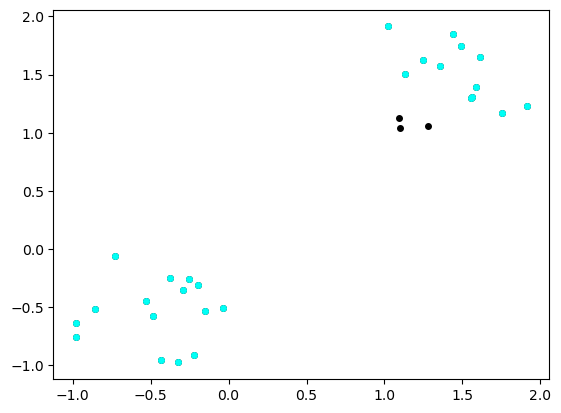

In [28]:
cmap = mpl.colormaps['hsv']

nb_clusters = sum(MM[:,0])

fig, ax = plt.subplots()
ax.plot(X[:,0], X[:,1], 'ko', markersize=4)
clu = 0
for i in range(len(mat)):
    if MM[i,0]:
        clu += 1
        for j in range(g.V):
            if mat[i, j + 6]:
                ax.plot(X[j,0], X[j,1], markersize=4, color=cmap(clu / (nb_clusters+1)), marker='o')

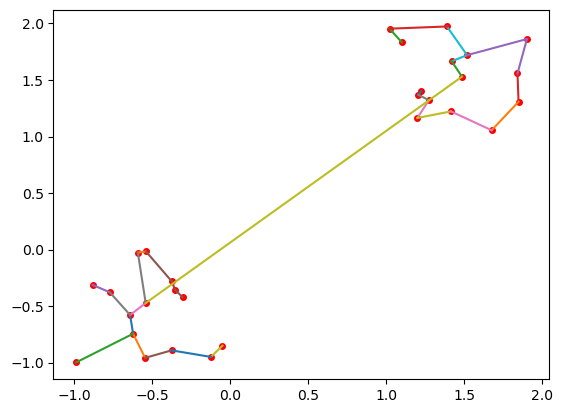

In [144]:
#a = np.random.rand(10,10)
hierarchy = g.hierarchy

fig, ax = plt.subplots()
container = []

ax.plot(X[:,0], X[:,1], 'ro', markersize=4)
#for v in hierarchy:
#    plt.plot(X[v[-1][0],0], X[v[-1][1],1])
#    plt.pause(0.01)

for v in hierarchy:
    line, = ax.plot(X[v[-1][:2]][:,0], X[v[-1][:2]][:,1])
    if len(container) > 0:
        container.append(container[-1] + [line])
    else: 
        container.append([line])
ani = animation.ArtistAnimation(fig, container, interval=400, blit=False)

writergif = animation.PillowWriter(fps=10)
ani.save('filename.gif',writer=writergif)

plt.show()